A simple pipeline for testing the classification. 

- Step 1: Load data
- Step 2: Load CLIP
    - Extract text features
    - Extract image features
- Step 3: Merge features
- Step 4: Train the classifier

In [ ]:
import torch  # PyTorch for deep learning
import pandas as pd  # Pandas for handling tabular data
import re
from transformers import CLIPTokenizer, CLIPProcessor, CLIPModel
from PIL import Image  # Pillow for image processing
from sklearn.model_selection import train_test_split  # Splitting data into training/testing sets
from sklearn.preprocessing import StandardScaler  # Feature scaling
from sklearn.ensemble import RandomForestClassifier  # A simple machine learning classifier
from sklearn.metrics import classification_report  # Evaluation metrics for classification
import numpy as np  # NumPy for numerical operations

c:\Users\sirifris\.conda\envs\ocr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import easyocr

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available, otherwise fallback to CPU
print(device)

cpu


In [4]:
df = pd.read_excel("E:/sample_images_full.xlsx")

In [5]:
# Load model and tokenizer
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

c:\Users\sirifris\.conda\envs\ocr\lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sirifris\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [6]:
# Define a funtion to clean up the texts a bit beforehand, e.g. convert emojis to text and remove URLs
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = emoji.demojize(text)  # Convert emojis to text (e.g., "😊" -> ":smiling_face:")
    text = re.sub(r'[:_]', ' ', text)  # Replace underscores/colons from emoji descriptions
    return text.strip()

In [7]:
# Function to truncate text at the token level
def bpe_truncate(text, max_tokens=77):
    """Ensures that the text does not exceed CLIP's token limit."""
    encoded = tokenizer.encode(text, add_special_tokens=False)  # Tokenize without special tokens

    if len(encoded) > max_tokens:
        truncated_tokens = encoded[:max_tokens]  # Keep only the first N tokens
        text = tokenizer.decode(truncated_tokens)  # Convert back to text
        print(f"⚠️ Truncated: {text}")  # Debugging
    
    return text

In [8]:
def get_text_features(text):
    """Extracts text embeddings from CLIP after ensuring text is within the token limit."""
    truncated_text = bpe_truncate(text)  # Ensure text is within token limit
    inputs = clip_processor(text=truncated_text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    return text_features.cpu().numpy()

In [9]:
reader = easyocr.Reader(["no", "en"])  # Norwegian and English

# Function to extract text from images:
def extract_text_easyocr(image_path):
    """Extracts text from an image using EasyOCR."""
    try:
        results = reader.readtext(image_path, detail=0)  # Extract text without coordinates
        return " ".join(results)  # Join extracted words into a single string
    except Exception as e:
        print(f"⚠️ OCR failed for {image_path}: {e}")
        return ""

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [10]:
# Function to extract image features
def get_image_features(image_path):
    """Extracts image embeddings from CLIP."""
    image = Image.open(image_path).convert("RGB")
    inputs = clip_processor(images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    return image_features.cpu().numpy()

In [11]:
# PIL.Image.ANTIALIAS = PIL.Image.LANCZOS

# Extract text from images
df["image_text"] = df["image_path_image_filename_image_1"].apply(extract_text_easyocr)

KeyboardInterrupt: 

In [ ]:
# Merge extracted text with tweet text
df["combined_text"] = df["tweet"] + " " + df["image_text"]

In [17]:
# Extract text and image features
df["text_features"] = df["tweet"].apply(get_text_features)

Token indices sequence length is longer than the specified maximum sequence length for this model (83 > 77). Running this sequence through the model will result in indexing errors


⚠️ Truncated: nrk forsiden : kvinne smittet av coronavirus i sverige https :// t . co / lsqk 4 uuwlk - direkte fra https :// t . co / eqp 6 4 timfe # nrknyheterrss # nrknyhetertoppsakerforsidenrss https :// t . co / n
⚠️ Truncated: nrk oslo og viken : folkehelsa om corona - karantene : – skaper unødig bekymring https :// t . co / w 8 9 kbigfu 0 - direkte fra https :// t . co / eqp 6 4 timfe # nrkdistrikttoppsakerrss # nrkdistrikttoppsakerosloo
⚠️ Truncated: tråd : disse ct - bildene av pasienter med coronavirus viser typiske lungefortetninger slik vi ser det ved # ards : bilaterale basale forteninger som reduserer volumet av lungevev med fungerende gassutveksling , også kalt " baby
⚠️ Truncated: nrk forsiden : skulle flytte inn i ny bolig - nå er den karantenesenter https :// t . co / aljn 9 vyenn - direkte fra https :// t . co / eqp 6 4 timfe # nrknyheterrss # nrknyhetertoppsakerforsidenrss https :// t .
⚠️ Truncated: nrk utenriks : skulle flytte inn i ny bolig - nå er den karantenese

In [19]:
df["image_features"] = df["image_path_image_filename_image_1"].apply(
    lambda x: get_image_features(x) if pd.notna(x) else None
)

c:\Users\sirifris\.conda\envs\ocr\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [20]:
def combine_features(text_emb, image_emb):
    """
    Combines text and image embeddings into a single vector.

    Parameters:
        text_emb (np.array): Text embedding vector (512-dim).
        image_emb (np.array): Image embedding vector (512-dim).

    Returns:
        np.array: Concatenated feature vector (1024-dim).
    """
    # Ensure embeddings are numpy arrays
    text_emb = np.array(text_emb).flatten()
    image_emb = np.array(image_emb).flatten()

    # Handle missing image embeddings (use zero vector if missing)
    if np.all(image_emb == 0):  
        print("⚠️ Missing image embedding, using only text features.")

    # Concatenate text and image features
    return np.concatenate([text_emb, image_emb])

# Apply the function to all rows
df["combined_features"] = df.apply(lambda row: combine_features(row["text_features"], row["image_features"]), axis=1)

In [21]:
print(df.head())

                                               tweet  label  \
0  Tror neppe jeg hadde klart å caste en kar som ...      3   
1  NRK forsiden: Kvinne smittet av Coronavirus i ...      0   
2  Da er vi sikra. Vaksinen mot Corona-viruset er...      3   
3  NRK Oslo og Viken: Folkehelsa om corona-karant...      0   
4  NRK Nordland: Ingen grunn til corona-bekymring...      0   

                    id       date  \
0  1221795275876044801 2020-01-01   
1  1223269853445779456 2020-01-01   
2  1221176911516356608 2020-01-01   
3  1221796006888529922 2020-01-01   
4  1222808933665914880 2020-01-01   

              image_path_image_filename_image_1  \
0  D:/Images/Covid/images_2/EPSwU1AXsAAQ_HD.jpg   
1  D:/Images/Covid/images_2/EPntcuPU8AIglrX.jpg   
2  D:/Images/Covid/images_2/EPJ97EGWkAMG55v.jpg   
3  D:/Images/Covid/images_2/EPSw_j9UUAAGgAN.jpg   
4  D:/Images/Covid/images_2/EPhKPrqUwAEcBJ6.jpg   

  image_path_image_filename_image_2 image_path_image_filename_image_3  \
0                 

In [22]:
print(df.dtypes)

tweet                                        object
label                                         int64
id                                            int64
date                                 datetime64[ns]
image_path_image_filename_image_1            object
image_path_image_filename_image_2            object
image_path_image_filename_image_3            object
image_path_image_filename_image_4            object
text_features                                object
image_features                               object
combined_features                            object
dtype: object


In [23]:
print(df["combined_features"].apply(lambda x: np.array(x).shape).value_counts())

combined_features
(1024,)    2177
Name: count, dtype: int64


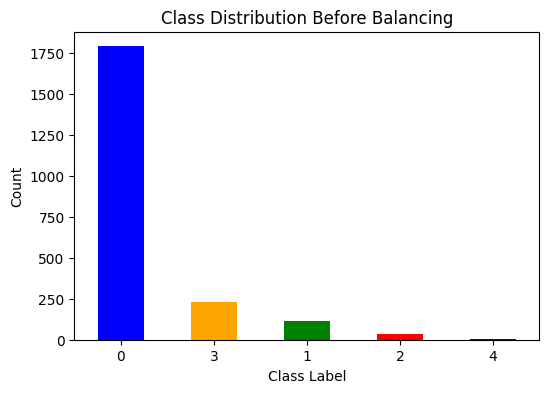

label
0    1789
3     231
1     117
2      37
4       3
Name: count, dtype: int64


In [24]:
import matplotlib.pyplot as plt

# Count occurrences of each label
class_counts = df["label"].value_counts()

# Plot class distribution
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color=["blue", "orange", "green", "red"])
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Distribution Before Balancing")
plt.xticks(rotation=0)
plt.show()

print(class_counts)  # Print exact numbers

In [25]:
# Convert multi-class labels to binary: 0 = non-humor, 1 = humor
df["label"] = df["label"].apply(lambda x: 1 if x in [1, 2, 3] else 0)

# Verify new class distribution
print(df["label"].value_counts())

label
0    1792
1     385
Name: count, dtype: int64


In [26]:
# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(df["combined_features"], df["label"], test_size=0.2, random_state=42, stratify=df["label"])

# Print dataset sizes
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")

Training set size: 1741, Test set size: 436


In [28]:
from imblearn.over_sampling import SMOTE

# Convert to NumPy arrays for SMOTE
X_train = np.array(X_train.tolist())  # Convert list of arrays to 2D NumPy array
y_train = np.array(y_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print new class distribution
from collections import Counter
print("Resampled class distribution:", Counter(y_train_resampled))

Resampled class distribution: Counter({np.int64(1): 1433, np.int64(0): 1433})


In [29]:
# Convert original and resampled feature sets to sets of tuples for comparison
original_feature_set = set(map(tuple, np.round(df["combined_features"], decimals=6)))  # Round to avoid floating-point precision errors
resampled_feature_set = set(map(tuple, np.round(X_train_resampled, decimals=6)))

# Find the synthetic samples (samples in resampled but not in original)
synthetic_features = resampled_feature_set - original_feature_set

# Convert back to a list for inspection
synthetic_samples = list(synthetic_features)

In [31]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert synthetic samples back to array
synthetic_array = np.array(synthetic_samples)

# Compute cosine similarity between first 5 synthetic samples and original data
for i in range(5):
    similarities = cosine_similarity(synthetic_array[i].reshape(1, -1), X_train)
    most_similar_idx = np.argmax(similarities)
    
    print(f"Synthetic sample {i+1} is most similar to real sample at index {most_similar_idx}")
    print(f"Cosine Similarity Score: {similarities[0, most_similar_idx]:.4f}\n")

Synthetic sample 1 is most similar to real sample at index 370
Cosine Similarity Score: 0.9932

Synthetic sample 2 is most similar to real sample at index 1664
Cosine Similarity Score: 0.9518

Synthetic sample 3 is most similar to real sample at index 754
Cosine Similarity Score: 0.9559

Synthetic sample 4 is most similar to real sample at index 976
Cosine Similarity Score: 1.0000

Synthetic sample 5 is most similar to real sample at index 1724
Cosine Similarity Score: 0.9471



In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the *original, imbalanced* test set
y_pred = clf.predict(np.array(X_test.tolist()))

# Print evaluation metrics
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8912    0.8217    0.8551       359
           1     0.3905    0.5325    0.4505        77

    accuracy                         0.7706       436
   macro avg     0.6409    0.6771    0.6528       436
weighted avg     0.8028    0.7706    0.7836       436



In [33]:
# Looking at the false predictions
df_test = pd.DataFrame({ "tweet": df.loc[X_test.index, "tweet"], 
                        "image_path": df.loc[X_test.index, "image_path_image_filename_image_1"],
                        "true_label": y_test,
                        "pred_label": y_pred})

# Extract misclassified samples
false_positives = df_test[(df_test["true_label"] == 0) & (df_test["pred_label"] == 1)]
false_negatives = df_test[(df_test["true_label"] == 1) & (df_test["pred_label"] == 0)]

# Display a few misclassified examples
print("\n🔹 False Positives (Non-humor misclassified as humor):")
print(false_positives.head(5))  # Show 5 examples

print("\n🔹 False Negatives (Humor misclassified as non-humor):")
print(false_negatives.head(5))  # Show 5 examples


🔹 False Positives (Non-humor misclassified as humor):
                                                  tweet  \
1765  Gjev pris til Korona- og vaksinasjonssenteret:...   
1854  Nå er det registrert ny koronasmitte her: Denn...   
1287  I disse pandemi-tider er det vogntog med også ...   
1064  Endelig! Svein på Ellingsrudhjemmet i Oslo vis...   
1611  Ja, USERNAME og USERNAME jeg lurer på hva dere...   

                                        image_path  true_label  pred_label  
1765  D:/Images/Covid/images_1/FGJXW56X0AAy8e8.jpg           0           1  
1854  D:/Images/Covid/images_1/FGuBzaUVkAAfcGL.jpg           0           1  
1287  D:/Images/Covid/images_2/Ev57d7LXYAQvFeC.jpg           0           1  
1064  D:/Images/Covid/images_2/EqPXUidXEAEvjWh.jpg           0           1  
1611  D:/Images/Covid/images_1/E8peoWAXoAA8R68.jpg           0           1  

🔹 False Negatives (Humor misclassified as non-humor):
                                                  tweet  \
1197  Så det v

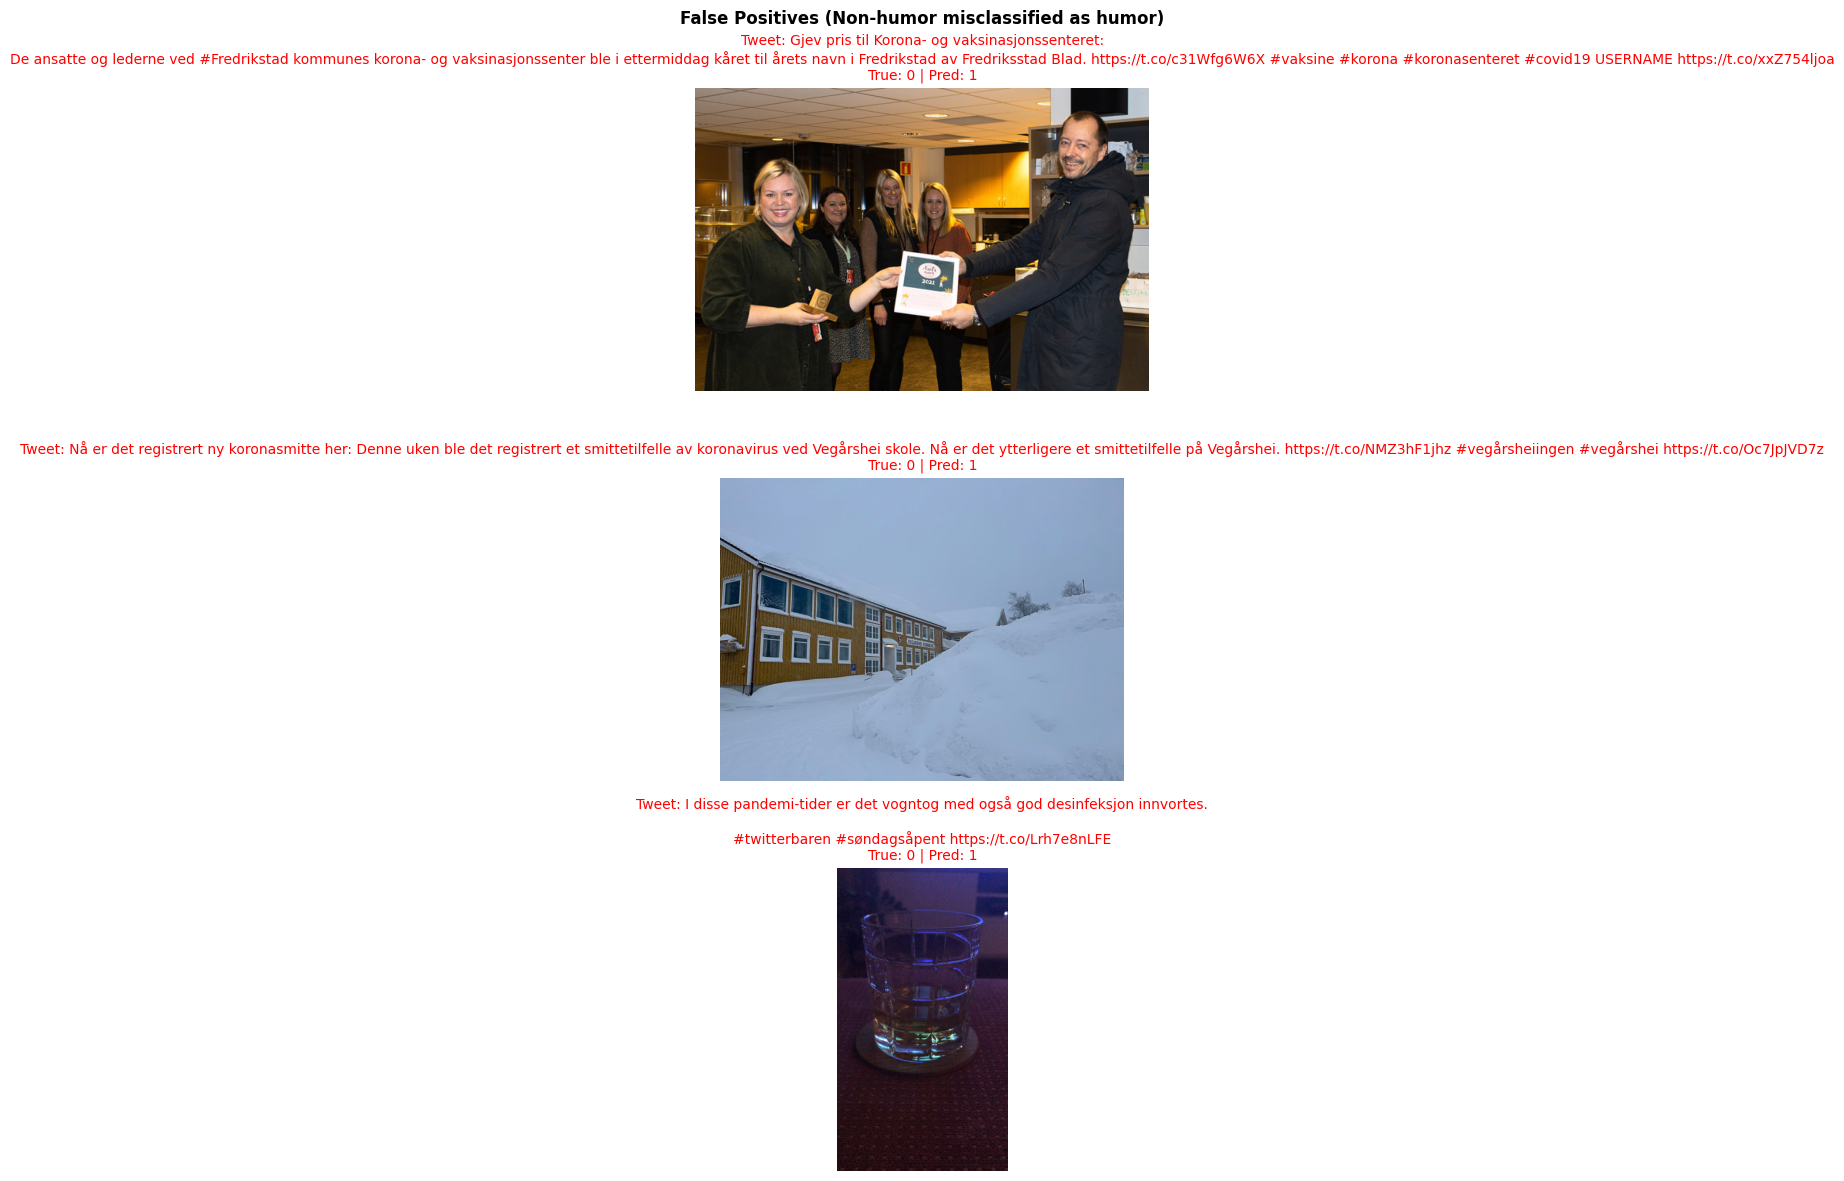

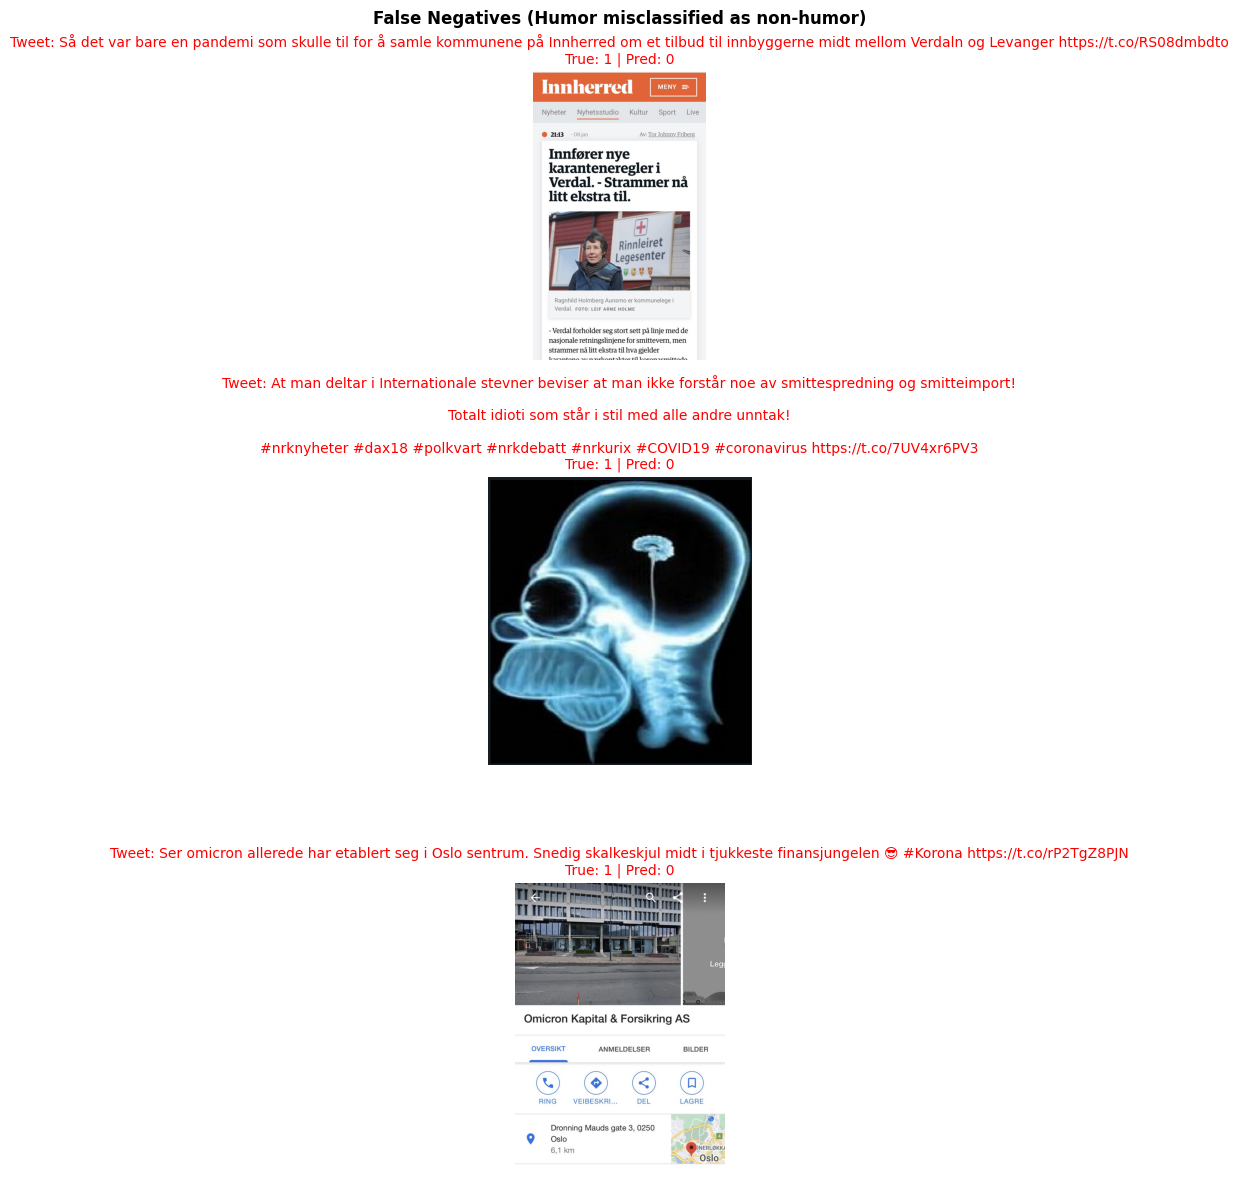

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_misclassified_samples(df_subset, title):
    """Displays misclassified examples with text and images."""
    fig, axes = plt.subplots(len(df_subset), 1, figsize=(8, len(df_subset) * 4))

    for i, (_, row) in enumerate(df_subset.iterrows()):
        # Load image if available
        img = mpimg.imread(row["image_path"]) if pd.notna(row["image_path"]) else None
        
        # Display image if present
        if img is not None:
            axes[i].imshow(img)
            axes[i].axis("off")

        # Display tweet text and labels
        text_info = f"Tweet: {row['tweet']}\nTrue: {row['true_label']} | Pred: {row['pred_label']}"
        axes[i].set_title(text_info, fontsize=10, color="red" if row['true_label'] != row['pred_label'] else "black")

    plt.suptitle(title, fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

# Show misclassified examples
show_misclassified_samples(false_positives.head(3), "False Positives (Non-humor misclassified as humor)")
show_misclassified_samples(false_negatives.head(3), "False Negatives (Humor misclassified as non-humor)")